# Train house price predictor

This notebook uses the MLpipeline class created in 'MLpipeline.py' to train a model that predicts houseprices in Dublin. It uses scraped data from the Irish property ads website Daft.ie enriched with information from open street maps. 

The scraping and enriching has already been done and the data is stored in "data/df_ads_mapdata.csv"

In [9]:
import pandas as pd
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from MLpipeline import MLpipeline


Loading the data and making a list of variables to be considered as features for the model.

In [10]:
df_ads = pd.read_csv('data/df_ads_mapdata.csv')

xlist = ['surface','area','property_type','ber_classification','seller_type',
         'selling_type','price_type','month','bathrooms','beds',
         'dist_to_centre','caferestaurants', 'churches', 'health', 
         'parks', 'platforms', 'pubs','schools', 'shops', 'sports', 
         'stations', 'latitude', 'longitude','parking']


Instantiating the machine learning pipeline class. The y variable is 'price' and all other variables are considered features as per the list above. The init prints out the info of the dataframe.

In [11]:
mlp = MLpipeline(df_ads)
mlp.prep_data(xlist)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16296 entries, 0 to 16497
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               16296 non-null  float64
 1   surface             13648 non-null  float64
 2   area                16295 non-null  object 
 3   property_type       16296 non-null  object 
 4   ber_classification  12547 non-null  object 
 5   seller_type         16296 non-null  object 
 6   selling_type        16232 non-null  object 
 7   price_type          16296 non-null  object 
 8   month               16296 non-null  object 
 9   bathrooms           16296 non-null  float64
 10  beds                16296 non-null  float64
 11  dist_to_centre      16296 non-null  float64
 12  caferestaurants     16296 non-null  int64  
 13  churches            16296 non-null  int64  
 14  health              16296 non-null  int64  
 15  parks               16296 non-null  int64  
 16  plat

The plot below shows that the log price is quite normally distributed but also that the tails are quite long, especially on the right. This makes sense as the most expensive house in the database is actually priced at 10 million euro.

In [12]:
px.histogram(x=mlp.y, nbins=200, marginal="box", labels={"x": "log price"})


Of the numerical features shown below, some of the values are not realistic, e.g. the max surface area. Some houses are also very abnormal with almost 30 bedrooms or bathrooms.

Because all these extreme cases can happen as well in any new data that may come in this is dealt with in the preprocessing pipeline.

In [13]:
mlp.X.describe()

,surface,bathrooms,beds,dist_to_centre,caferestaurants,churches,health,parks,platforms,pubs,schools,shops,sports,stations,latitude,longitude
count,13648.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000,16296.000000
mean,297.128776,1.886046,2.844870,8.201968,6.744477,1.192256,0.224963,2.743311,11.805412,3.284242,1.394023,18.748343,5.252946,0.757118,53.350288,-6.270497
std,11503.642558,1.124673,1.255851,5.823100,21.988931,1.887161,0.617396,3.326124,10.553721,9.206663,1.417702,38.295357,5.262938,1.744050,0.070954,0.090635
min,0.500000,0.000000,0.000000,0.351459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.149727,-6.565483
25%,72.000000,1.000000,2.000000,3.938942,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,1.000000,1.000000,0.000000,53.297258,-6.323537
50%,93.000000,2.000000,3.000000,7.188527,1.000000,1.000000,0.000000,2.000000,10.000000,1.000000,1.000000,6.000000,4.000000,0.000000,53.341380,-6.264915
75%,125.000000,2.000000,3.000000,11.112312,4.000000,1.250000,0.000000,4.000000,15.000000,3.000000,2.000000,18.000000,8.000000,0.000000,53.382934,-6.208374
max,937498.805670,29.000000,29.000000,31.152948,319.000000,16.000000,5.000000,38.000000,144.000000,124.000000,7.000000,464.000000,38.000000,15.000000,53.615694,-6.048880


Splitting the data into a testing and training dataset.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(mlp.X, mlp.y, test_size=0.2, random_state=42)

mlp.build_preprocessor(X_train)

R squared: 0.7991
RMSE: 0.2349
Tuned best parameters: {}


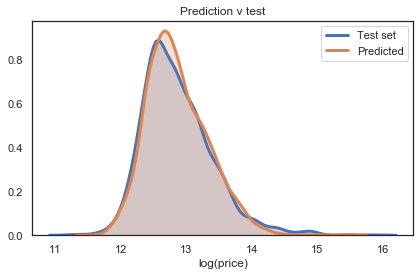

In [15]:
from sklearn.linear_model import LinearRegression

mlp_linreg = mlp

parametersGrid = {}

mlp_linreg.fit_model(y_train, LinearRegression(), parametersGrid)
mlp_linreg.evaluate_model(X_test, y_test)


In [8]:
from sklearn.ensemble import RandomForestRegressor

mlp_rf = mlp

parametersGrid = {'rf__n_estimators': [300,500,700,900],
                  'rf__max_features': ['auto',None,'log2'],
                  'rf__min_samples_leaf': [1,5,20,50]}

estimator = RandomForestRegressor(random_state=42)

mlp_rf.fit_model(y_train, estimator, parametersGrid)
mlp_rf.evaluate_model(X_test, y_test)


KeyboardInterrupt: 

In [ ]:
from xgboost import XGBRegressor

mlp_xgb = mlp

parametersGrid = {'xgb__n_estimators': [900,1300,1500,1700,2000],
                  'xgb__max_depth': [3,5,7,9,11],
                  'xgb__learning_rate': [0.01,0.1,0.3],
                  'xgb__gamma': [0.0, 0.2, 0.4],
                  'xgb__colsample_bytree': [0.3,0.5,0.7,1]}

estimator = XGBRegressor(objective='reg:squarederror', random_state=42)

mlp_xgb.fit_model(y_train, estimator, parametersGrid)
mlp_xgb.evaluate_model(X_test, y_test)
